In [1]:
import pandas as pd
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from math import pi,sin,cos,acos,asin
import numpy as np
import seaborn as sns
from scipy.stats import linregress
import math
from ml_metrics import rmse,mae
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import minimize
from matplotlib.ticker import PercentFormatter
from scipy.optimize import fsolve
import matplotlib.ticker as ticker

In [2]:
def cosd(b):
    return cos(math.radians(b))
def sind(a):
    return sin(math.radians(a))
def tand(f):
    return tan(math.radians(f))
def acosd(d):
    return math.degrees(acos(d))
def asind(c):
    return math.degrees(asin(c))

In [3]:
df=pd.read_csv('DynamicLineRating_2019_2.csv')
df['UT_Time']= df.JulianTime.apply(lambda x: datetime.strptime(x,'%m/%d/%Y %H:%M'))
df['LocalTime'] = df['UT_Time'] + timedelta(hours = 7)


In [4]:
def day(LocalTime):
    return float(datetime.strftime(LocalTime,'%d'))
df['Day'] = df.LocalTime.apply(lambda x:(day(x)))
def month(LocalTime):
    #local_Time = UT_Time + timedelta(hours = 7)
    return float(datetime.strftime(LocalTime,'%m'))
df['Month'] = df.LocalTime.apply(lambda x:(month(x)))

In [5]:
m = 1
n =7

In [6]:
time = np.array(df.LocalTime[(df.Month.isin([m]))&(df['Day']<32)])

In [7]:
Ta = np.array(df.Temp_ThHyg1_degC_avg)#[(df.Month.isin([m]))&(df['Day']<32)]) #ambientTemp
Wv = np.array(df.WindSpeed_Anemo1_ms_avg)#[(df.Month.isin([m]))&(df['Day']<32)]) #windVelocity #[(df.Month.isin([m]))&(df['Day']<32)]
#Wd_northbase = np.array(df.WindDir_Wvane1_deg_avg360) #windDirection
qs = np.array(df.GHI_ThPyra1_Wm2_avg)#[(df.Month.isin([m]))&(df['Day']<32)]) #solarIrradiance
df['WindDirection']= df.WindDir_Wvane1_deg_avg360.apply(lambda x: abs(205.46-x) 
                           if abs(205.46-x) <= 90 
                           else (abs(180-abs(205.46-x)) if abs(205.46-x) > 90 else 0))
Wd=np.array(df.WindDirection)


In [8]:
def wind(x):
    if abs(205.46-x) <= 90:
        return abs(205.46-x)
    elif abs(205.46-x) > 90:
        return (abs(180-abs(205.46-x)))
    else:
        return 0

In [9]:
df['WindDirection']= df.WindDir_Wvane1_deg_avg360.apply(lambda x: abs(205.46-x) 
                           if abs(205.46-x) <= 90 
                           else (abs(180-abs(205.46-x)) if abs(205.46-x) > 90 else 0))
Wd=np.array(df.WindDirection)


In [10]:
Ts = 100 # maximum allowable Temp
def Re(Ta,Wv):
    #Ta = 25 # ambient temp
    Ts = 100 # maximum allowable Temp
    Tf = (Ts+Ta)/2 # temp of boundary layer
    Do = 0.0309 # Conductor diameter
    He = 10 # elevation
    p = (1.293-1.525*10**(-4)*He + 6.379*10**(-9)*He**2)/(1+0.00367*Tf) # air density
    u = (1.458*10**(-6)*(Tf+273)**1.5)/(Tf+383.4) # dynamic viscosity of air
    # Wv = # wind velocity
    return Do*p*Wv/u

In [11]:
def Qc(Ta,Wd,Wv):
    #Ta = 25 # ambient temp
    Ts = 100 # maximum allowable Temp
    Tf = (Ts+Ta)/2 # temp of boundary layer
    Do = 0.0309 # Conductor diameter
    He = 10 # elevation
    p = (1.293-1.525*10**(-4)*He + 6.379*10**(-9)*He**2)/(1+0.00367*Tf) # air density
    u = (1.458*(10**(-6))*((Tf+273)**1.5))/(Tf+383.4) # dynamic viscosity of air
    # Wv = # wind velocity
    
    #Wd = 90 # angle of wind direction and conductor axis
    kf = 2.424*10**(-2)+7.477*10**(-5)*Tf - 4.407*10**(-9)*Tf**2 # thermal conductivity of air
    K = 1.194-cosd(Wd)+0.194*cosd(2*Wd)+0.368*sind(2*Wd) #wind direction factor
    q1= K*(1.01+1.35*(Re(Ta,Wv)**0.52))*kf*(Ts-Ta) #1.35 w/m correct at low wind speeds
    q2= K*0.754*(Re(Ta,Wv)**0.6)*kf*(Ts-Ta)  #0.754 w/m correct at high wind speeds
    # Choose the larger of (q1,q2)
    q3 = 3.645*(p**0.5)*(Do**0.75)*((Ts-Ta)**1.25) # 3.645 at low Wv use the larger of forced and natural
    
    if Wv <= 0.2:
        return max(q1,q2,q3)
    else:
        return max(q1,q2)

In [12]:
def K_a(Wd):
    return 1.194-cosd(Wd)+0.194*cosd(2*Wd)+0.368*sind(2*Wd)

In [13]:
def eff_wind(Ta,Wd,Wv):
    #Ta = 25 # ambient temp
    Ts = 100 # maximum allowable Temp
    Tf = (Ts+Ta)/2 # temp of boundary layer
    Do = 0.0309 # Conductor diameter
    He = 10 # elevation
    p = (1.293-1.525*10**(-4)*He + 6.379*10**(-9)*He**2)/(1+0.00367*Tf) # air density
    u = (1.458*(10**(-6))*((Tf+273)**1.5))/(Tf+383.4) # dynamic viscosity of air
#Do*p*Wv/u
    # Wv = # wind velocity
    #Wd = 90 # angle of wind direction and conductor axis
    kf = 2.424*10**(-2)+7.477*10**(-5)*Tf - 4.407*10**(-9)*Tf**2 # thermal conductivity of air
    K = 1.194-cosd(Wd)+0.194*cosd(2*Wd)+0.368*sind(2*Wd) #wind direction factor
    q1= K*(1.01+1.35*(Re(Ta,Wv)**0.52))*kf*(Ts-Ta) #1.35 w/m correct at low wind speeds
    q2= K*0.754*(Re(Ta,Wv)**0.6)*kf*(Ts-Ta)  #0.754 w/m correct at high wind speeds
    # Choose the larger of (q1,q2)
    q3 = 3.645*(p**0.5)*(Do**0.75)*((Ts-Ta)**1.25) # 3.645 at low Wv use the larger of forced and natural   
    
    if q1>q2:
        return (((K_a(Wd)*(1.01+1.35*(Re(Ta,Wv)**0.52))/K_a(90)-1.01)/1.35)**(1/0.52))*u/(Do*p)
    else:
        return ((K_a(Wd)*(Re(Ta,Wv)**0.6)/K_a(90))**(1/0.6))*u/(Do*p)

In [14]:
eff_wind(25,30,5)

3.052148552697625

In [15]:
Eff_WindSpeed = np.array([eff_wind(Ta[i], Wd[i], Wv[i]) for i in range(len(Ta))])
#sns.distplot(Eff_WindSpeed,color='navy',label='Jan',bins=50, hist=False)
#print(Eff_WindSpeed)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


In [16]:
dataframe=pd.DataFrame(Eff_WindSpeed, columns=['eff_wind'])
print(dataframe)

        eff_wind
0       0.799069
1       0.693951
2       0.863629
3       1.006984
4       1.280637
...          ...
525595  0.901314
525596  1.260745
525597  1.095467
525598  0.817491
525599  1.717601

[525600 rows x 1 columns]


In [17]:
sns.distplot(np.array(df.dataframe[(df['Month']==1)]),color='navy',label='Jan',bins=50, hist=False)
sns.distplot(np.array(df.dataframe[(df['Month']==2)]),color='khaki',label='Feb',bins=50, hist=False)
sns.distplot(np.array(df.dataframe[(df['Month']==3)]),label='Mar',bins=50, hist=False)
sns.distplot(np.array(df.dataframe[(df['Month']==4)]),label='Apl',bins=50, hist=False)
sns.distplot(np.array(df.dataframe[(df['Month']==5)]),label='May',bins=50, hist=False)
sns.distplot(np.array(df.dataframe[(df['Month']==6)]),label='Jun',bins=50, hist=False)
sns.distplot(np.array(df.dataframe[(df['Month']==7)]),label='Jul',bins=50, hist=False)
sns.distplot(np.array(df.dataframe[(df['Month']==8)]),label='Aug',bins=50, hist=False)
sns.distplot(np.array(df.dataframe[(df['Month']==9)]),label='Sep',bins=50, hist=False)
sns.distplot(np.array(df.dataframe[(df['Month']==10)]),label='Oct',bins=50, hist=False)
sns.distplot(np.array(df.dataframe[(df['Month']==11)]),label='Nov',bins=50, hist=False)
#fig, ax = plt.subplots()
#ax.hist(amp_plot,bins=50,edgecolor='black')
#plt.axvline(x=940, color='red',linewidth=2,label='SLR: 940 A')
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Wind Speed (m/s)',fontsize=11)
plt.ylabel('Frequency',fontsize=11)
#plt.legend()
plt.title('Distribution Plot of Wind Speed in 2019',fontsize=11)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
#plt.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(amp_plot)))
plt.show()

AttributeError: 'DataFrame' object has no attribute 'dataframe'

In [ ]:
#fsolve(K(30)*(1.01+1.35*(Re(25,5)**0.52))-K(90)*(1.01+1.35*(Re(25,Wv_eff[1])**0.52)))

In [18]:
def Qr(Ta):
    Do=0.0309
    Ts=100
    e = 0.7# emissivity
    return 17.8*Do*e*(1/10**8)*((Ts+273)**4-(Ta+273)**4)

In [19]:
a = 0.9 # absorbsibility
Do = 0.0309 # Conductor diameter
def Qs(qs):
    return a*Do*qs

In [20]:
def R(Ta): 
    R_low = 0.0983/1609.344
    R_high = 0.117/1609.344
    T_low = 25
    T_high = 75
    Ts =100
    Tf =0.5*(Ts+Ta)
    return R_low + (R_high-R_low)*(Tf-T_low)/(T_high-T_low)+R_low

In [21]:
def I_3E(Ta,qs,Wv,Wd):
    return math.sqrt((Qc(Ta,Wd,Wv)+Qr(Ta)-Qs(qs))/R(Ta))
#Time = np.array(df.LocalTime[(df['Month']==m)&(df['Day']<15)])


In [22]:
amp_plot =np.array([I_3E(Ta[i], qs[i], Wv[i], Wd[i]) for i in range(len(Ta))])

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


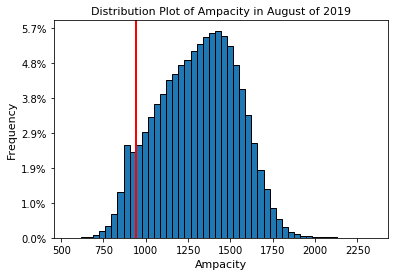

In [23]:
#freq=sns.distplot(amp_plot)
fig, ax = plt.subplots()
#y = np.linspace(0,11,100)
#x = [940 for i in freq]
#.plot(freq,x,color='red',linewidth=2)
ax.hist(amp_plot,bins=50,edgecolor='black')
ax.axvline(x=940, color='red',linewidth=2,label='static rating 940 A')
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel('Ampacity',fontsize=11)
ax.set_ylabel('Frequency',fontsize=11)
#plt.legend()
ax.set_title('Distribution Plot of Ampacity in August of 2019',fontsize=11)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(amp_plot)))
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


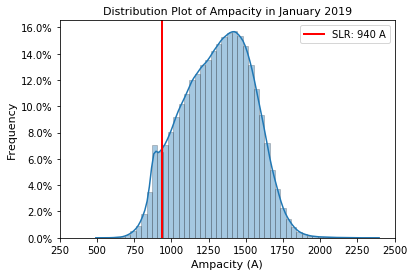

In [24]:
sns.distplot(amp_plot,bins=50,hist_kws=dict(edgecolor="black",linewidth=0.5))
#fig, ax = plt.subplots()
#ax.hist(amp_plot,bins=50,edgecolor='black')
plt.axvline(x=940, color='red',linewidth=2,label='SLR: 940 A')
#locs, labels = xticks()
#plt.xticks(np.arange(300,2500,step=250))
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Ampacity (A)',fontsize=11)
plt.ylabel('Frequency',fontsize=11)
plt.legend()
plt.title('Distribution Plot of Ampacity in January 2019',fontsize=11)
ax = plt.subplot()
ax.set_xticks(range(250,2750,250))
ax.set_xticklabels(range(250,2750,250))
#yx = plt.subplot()
#yx.set_yticks(range(0,18,2))
#yx.set_yticklabels(range(0,18,2))
#plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d%%'))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=0.01))
#plt.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(amp_plot)))
plt.show()

In [25]:
Ta_mp = np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==6)&(df['Day'].isin([21,22]))]) #ambientTemp
Wv_mp = np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==6)&(df['Day'].isin([21,22]))]) #windVelocity
#Wd_northbase = np.array(df.WindDir_Wvane1_deg_avg360) #windDirection
qs_mp = np.array(df.GHI_ThPyra1_Wm2_avg[(df['Month']==6)&(df['Day'].isin([21,22]))]) #solarIrradiance

#df['WindDirection']= df.WindDir_Wvane1_deg_avg360.apply(lambda x: abs(205.46-x) 
#                           if abs(205.46-x) <= 90 
#                           else abs(180-abs(205.46-x)))
Wd_mp=np.array(df.WindDirection[(df['Month']==6)&(df['Day'].isin([21,22]))])
time_mp = np.array(df.LocalTime[(df['Month']==6)&(df['Day'].isin([21,22]))])
amp_plot_mp =np.array([I_3E(Ta_mp[i], qs_mp[i], Wv_mp[i], Wd_mp[i]) for i in range(len(Ta_mp))])

In [26]:
Wd_mp=np.array(df.WindDirection[(df['Month']==m)&(df['Day'].isin([21,22]))])
time_mp = np.array(df.LocalTime[(df['Month']==m)&(df['Day'].isin([21,22]))])

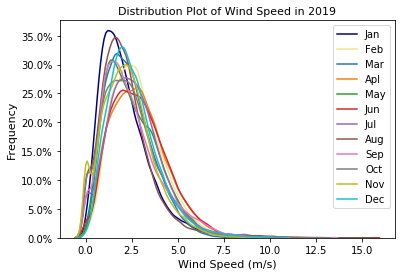

In [37]:
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==1)]),color='navy',label='Jan',bins=50, hist=False)
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==2)]),color='khaki',label='Feb',bins=50, hist=False)
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==3)]),label='Mar',bins=50, hist=False)
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==4)]),label='Apl',bins=50, hist=False)
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==5)]),label='May',bins=50, hist=False)
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==6)]),label='Jun',bins=50, hist=False)
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==7)]),label='Jul',bins=50, hist=False)
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==8)]),label='Aug',bins=50, hist=False)
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==9)]),label='Sep',bins=50, hist=False)
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==10)]),label='Oct',bins=50, hist=False)
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==11)]),label='Nov',bins=50, hist=False)
sns.distplot(np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==12)]),label='Dec',bins=50, hist=False)
#fig, ax = plt.subplots()
#ax.hist(amp_plot,bins=50,edgecolor='black')
#plt.axvline(x=940, color='red',linewidth=2,label='SLR: 940 A')
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Wind Speed (m/s)',fontsize=11)
plt.ylabel('Frequency',fontsize=11)
#plt.legend()
plt.title('Distribution Plot of Wind Speed in 2019',fontsize=11)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
#plt.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(amp_plot)))
plt.show()

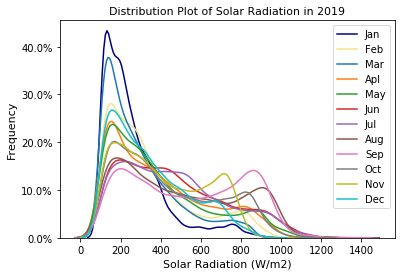

In [36]:
sns.distplot(np.array(df.GHI_ThPyra1_Wm2_avg[(df['Month']==1)&(df.GHI_ThPyra1_Wm2_avg>=100)]),color='navy',label='Jan',bins=50, hist=False)
sns.distplot(np.array(df.GHI_ThPyra1_Wm2_avg[(df['Month']==2)&(df.GHI_ThPyra1_Wm2_avg>=100)]),color='khaki',label='Feb',bins=50, hist=False)
sns.distplot(np.array(df.GHI_ThPyra1_Wm2_avg[(df['Month']==3)&(df.GHI_ThPyra1_Wm2_avg>=100)]),label='Mar',bins=50, hist=False)
sns.distplot(np.array(df.GHI_ThPyra1_Wm2_avg[(df['Month']==4)&(df.GHI_ThPyra1_Wm2_avg>=100)]),label='Apl',bins=50, hist=False)
sns.distplot(np.array(df.GHI_ThPyra1_Wm2_avg[(df['Month']==5)&(df.GHI_ThPyra1_Wm2_avg>=100)]),label='May',bins=50, hist=False)
sns.distplot(np.array(df.GHI_ThPyra1_Wm2_avg[(df['Month']==6)&(df.GHI_ThPyra1_Wm2_avg>=100)]),label='Jun',bins=50, hist=False)
sns.distplot(np.array(df.GHI_ThPyra1_Wm2_avg[(df['Month']==7)&(df.GHI_ThPyra1_Wm2_avg>=100)]),label='Jul',bins=50, hist=False)
sns.distplot(np.array(df.GHI_ThPyra1_Wm2_avg[(df['Month']==8)&(df.GHI_ThPyra1_Wm2_avg>=100)]),label='Aug',bins=50, hist=False)
sns.distplot(np.array(df.GHI_ThPyra1_Wm2_avg[(df['Month']==9)&(df.GHI_ThPyra1_Wm2_avg>=100)]),label='Sep',bins=50, hist=False)
sns.distplot(np.array(df.GHI_ThPyra1_Wm2_avg[(df['Month']==10)&(df.GHI_ThPyra1_Wm2_avg>=100)]),label='Oct',bins=50, hist=False)
sns.distplot(np.array(df.GHI_ThPyra1_Wm2_avg[(df['Month']==11)&(df.GHI_ThPyra1_Wm2_avg>=100)]),label='Nov',bins=50, hist=False)
sns.distplot(np.array(df.GHI_ThPyra1_Wm2_avg[(df['Month']==12)&(df.GHI_ThPyra1_Wm2_avg>=100)]),label='Dec',bins=50, hist=False)
#fig, ax = plt.subplots()
#ax.hist(amp_plot,bins=50,edgecolor='black')
#plt.axvline(x=940, color='red',linewidth=2,label='SLR: 940 A')
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Solar Radiation (W/m2)',fontsize=11)
plt.ylabel('Frequency',fontsize=11)
#plt.legend()
plt.title('Distribution Plot of Solar Radiation in 2019',fontsize=11)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=0.01))
#plt.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(amp_plot)))
plt.show()

In [29]:
T1 = np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==1)]) #ambientTemp
V1 = np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==1)]) #windVelocity #[(df.Month.isin([m]))&(df['Day']<32)]
df['Wind_Direction']= df.WindDir_Wvane1_deg_avg360.apply(wind)
D1=np.array(df.Wind_Direction[(df['Month']==1)])

T2 = np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==2)]) #ambientTemp
V2 = np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==2)])
D2=np.array(df.Wind_Direction[(df['Month']==2)])

T3 = np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==3)]) #ambientTemp
V3 = np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==3)])
D3=np.array(df.Wind_Direction[(df['Month']==3)])

T4 = np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==4)]) #ambientTemp
V4 = np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==4)])
D4=np.array(df.Wind_Direction[(df['Month']==4)])

T5 = np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==5)]) #ambientTemp
V5 = np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==5)])
D5=np.array(df.Wind_Direction[(df['Month']==5)])

T6 = np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==6)]) #ambientTemp
V6 = np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==6)])
D6=np.array(df.Wind_Direction[(df['Month']==6)])

T7 = np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==7)]) #ambientTemp
V7 = np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==7)])
D7=np.array(df.Wind_Direction[(df['Month']==7)])

T8 = np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==8)]) #ambientTemp
V8 = np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==8)])
D8=np.array(df.Wind_Direction[(df['Month']==8)])

T9 = np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==9)]) #ambientTemp
V9 = np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==9)])
D9=np.array(df.Wind_Direction[(df['Month']==9)])

T10 = np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==10)]) #ambientTemp
V10 = np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==10)])
D10=np.array(df.Wind_Direction[(df['Month']==10)])

T11 = np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==11)]) #ambientTemp
V11 = np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==11)])
D11=np.array(df.Wind_Direction[(df['Month']==11)])

T12 = np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==12)]) #ambientTemp
V12 = np.array(df.WindSpeed_Anemo1_ms_avg[(df['Month']==12)])
D12=np.array(df.Wind_Direction[(df['Month']==12)])

In [30]:
eff_WindSpeed1 = np.array([eff_wind(T1[i], D1[i], V1[i]) for i in range(len(T1))])
eff_WindSpeed2 = np.array([eff_wind(T2[i], D2[i], V2[i]) for i in range(len(T2))])
eff_WindSpeed3 = np.array([eff_wind(T3[i], D3[i], V3[i]) for i in range(len(T3))])
eff_WindSpeed4 = np.array([eff_wind(T4[i], D4[i], V4[i]) for i in range(len(T4))])
eff_WindSpeed5 = np.array([eff_wind(T5[i], D5[i], V5[i]) for i in range(len(T5))])
eff_WindSpeed6 = np.array([eff_wind(T6[i], D6[i], V6[i]) for i in range(len(T6))])
eff_WindSpeed7 = np.array([eff_wind(T7[i], D7[i], V7[i]) for i in range(len(T7))])
eff_WindSpeed8 = np.array([eff_wind(T8[i], D8[i], V8[i]) for i in range(len(T8))])
eff_WindSpeed9 = np.array([eff_wind(T9[i], D9[i], V9[i]) for i in range(len(T9))])
eff_WindSpeed10 = np.array([eff_wind(T10[i], D10[i], V10[i]) for i in range(len(T10))])
eff_WindSpeed11 = np.array([eff_wind(T11[i], D11[i], V11[i]) for i in range(len(T11))])
eff_WindSpeed12 = np.array([eff_wind(T12[i], D12[i], V12[i]) for i in range(len(T12))])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


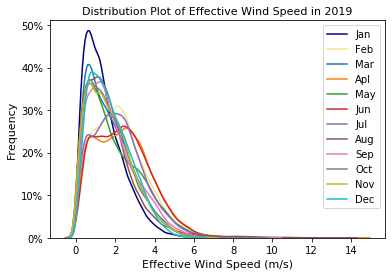

In [31]:
sns.distplot(eff_WindSpeed1,color='navy',label='Jan',bins=50, hist=False)
sns.distplot(eff_WindSpeed2,color='khaki',label='Feb',bins=50, hist=False)
sns.distplot(eff_WindSpeed3,label='Mar',bins=50, hist=False)
sns.distplot(eff_WindSpeed4,label='Apl',bins=50, hist=False)
sns.distplot(eff_WindSpeed5,label='May',bins=50, hist=False)
sns.distplot(eff_WindSpeed6,label='Jun',bins=50, hist=False)
sns.distplot(eff_WindSpeed7,label='Jul',bins=50, hist=False)
sns.distplot(eff_WindSpeed8,label='Aug',bins=50, hist=False)
sns.distplot(eff_WindSpeed9,label='Sep',bins=50, hist=False)
sns.distplot(eff_WindSpeed10,label='Oct',bins=50, hist=False)
sns.distplot(eff_WindSpeed11,label='Nov',bins=50, hist=False)
sns.distplot(eff_WindSpeed12,label='Dec',bins=50, hist=False)
plt.xlabel('Effective Wind Speed (m/s)',fontsize=11)
plt.ylabel('Frequency',fontsize=11)
#plt.legend()
plt.title('Distribution Plot of Effective Wind Speed in 2019',fontsize=11)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
#plt.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(amp_plot)))
plt.show()

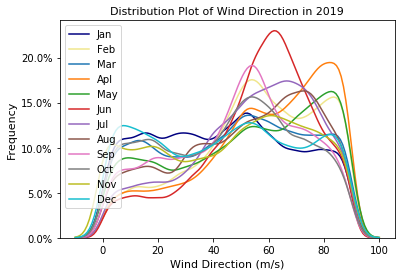

In [32]:
sns.distplot(np.array(df.Wind_Direction[(df['Month']==1)]),color='navy',label='Jan',bins=50, hist=False)
sns.distplot(np.array(df.Wind_Direction[(df['Month']==2)]),color='khaki',label='Feb',bins=50, hist=False)
sns.distplot(np.array(df.Wind_Direction[(df['Month']==3)]),label='Mar',bins=50, hist=False)
sns.distplot(np.array(df.Wind_Direction[(df['Month']==4)]),label='Apl',bins=50, hist=False)
sns.distplot(np.array(df.Wind_Direction[(df['Month']==5)]),label='May',bins=50, hist=False)
sns.distplot(np.array(df.Wind_Direction[(df['Month']==6)]),label='Jun',bins=50, hist=False)
sns.distplot(np.array(df.Wind_Direction[(df['Month']==7)]),label='Jul',bins=50, hist=False)
sns.distplot(np.array(df.Wind_Direction[(df['Month']==8)]),label='Aug',bins=50, hist=False)
sns.distplot(np.array(df.Wind_Direction[(df['Month']==9)]),label='Sep',bins=50, hist=False)
sns.distplot(np.array(df.Wind_Direction[(df['Month']==10)]),label='Oct',bins=50, hist=False)
sns.distplot(np.array(df.Wind_Direction[(df['Month']==11)]),label='Nov',bins=50, hist=False)
sns.distplot(np.array(df.Wind_Direction[(df['Month']==12)]),label='Dec',bins=50, hist=False)
#fig, ax = plt.subplots()
#ax.hist(amp_plot,bins=50,edgecolor='black')
#plt.axvline(x=940, color='red',linewidth=2,label='SLR: 940 A')
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Wind Direction (m/s)',fontsize=11)
plt.ylabel('Frequency',fontsize=11)
#plt.legend()
plt.title('Distribution Plot of Wind Direction in 2019',fontsize=11)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=0.1))
#plt.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(amp_plot)))
plt.show()

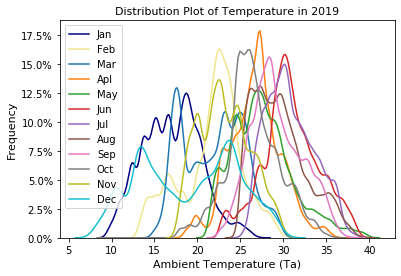

In [33]:
sns.distplot(np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==1)]),color='navy',label='Jan',bins=50, hist=False)
sns.distplot(np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==2)]),color='khaki',label='Feb',bins=50, hist=False)
sns.distplot(np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==3)]),label='Mar',bins=50, hist=False)
sns.distplot(np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==4)]),label='Apl',bins=50, hist=False)
sns.distplot(np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==5)]),label='May',bins=50, hist=False)
sns.distplot(np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==6)]),label='Jun',bins=50, hist=False)
sns.distplot(np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==7)]),label='Jul',bins=50, hist=False)
sns.distplot(np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==8)]),label='Aug',bins=50, hist=False)
sns.distplot(np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==9)]),label='Sep',bins=50, hist=False)
sns.distplot(np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==10)]),label='Oct',bins=50, hist=False)
sns.distplot(np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==11)]),label='Nov',bins=50, hist=False)
sns.distplot(np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==12)]),label='Dec',bins=50, hist=False)
#sns.distplot(np.array(df.Temp_ThHyg1_degC_avg[(df['Month']==12)]),label='Dec',bins=50, hist=False)
#fig, ax = plt.subplots()
#ax.hist(amp_plot,bins=50,edgecolor='black')
#plt.axvline(x=940, color='red',linewidth=2,label='SLR: 940 A')
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Ambient Temperature (Ta)',fontsize=11)
plt.ylabel('Frequency',fontsize=11)
#plt.legend()
plt.title('Distribution Plot of Temperature in 2019',fontsize=11)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
#plt.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(amp_plot)))
plt.show()